# Load libraries and Data

In [1]:
from pyhive import presto

def get_presto_conn():
    # need to impersonate to the owner to drop exisiting tables
    return presto.connect(host='presto-alpha-backend.data.houzz.net', port=8086, username='wandajuan')

def presto_query(query, presto_conn, fetchall=True):
    cursor = presto_conn.cursor()
    cursor.execute(query)
    header = list(map(operator.itemgetter(0), cursor.description))
    return header, cursor.fetchall()
conn = get_presto_conn() 

import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)

from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

# MP dWeb best seller labels v2

In [38]:
# latest ramp period
start_date = '2022-05-18'
end_date = '2022-05-24'
test_name = 'mp_dweb_best_seller_label_v2'
control = 'control'
treatment = 'treatment_b'
device_cat = "('Personal computer')" 
# device_cat = "('Tablet','Smartphone')"
tmp_visitor_base = 'wandajuan.visitor_base_' + test_name
tmp_mp_metrics = 'wandajuan.mp_metrics_' + test_name
tmp_xo_metrics = 'wandajuan.xo_metrics_' + test_name
tmp_browse_ranking = 'wandajuan.browse_ranking_' + test_name
tmp_final_table = 'wandajuan.' + test_name

## User Base

In [4]:
# Test user base:

q = """DROP TABLE IF EXISTS {tmp_visitor_base}""".format(tmp_visitor_base=tmp_visitor_base)
print(pd.read_sql(q, conn))

print('run query below in presto:')


q = """
CREATE TABLE {tmp_visitor_base} AS
with first_trigger as
    (
    SELECT 
       visitor_id
       , min(test_variant) as test_value_min
       , max(test_variant) as test_value_max
       , min(dt) as ft_dt
    FROM l2.test_selection
    WHERE test_name = '{test_name}'
    and dt BETWEEN '{start_date}' AND '{end_date}'
    and visitor_id in (
                        select distinct visitor_id
                            from l2.session_analytics core 
                        WHERE core.dt BETWEEN '{start_date}' AND '{end_date}'
                          and CAST(country as varchar) in ('US') 
                          and CAST(site_id as varchar) in ('101') 
                          AND device_cat != '' 
                          AND (test_set like '%{test_name}=%') 
                          and device_cat in {device_cat}
                          and session_id not in (
                                            select session_id 
                                            from l2.session_summary 
                                            where user_agent like '%test_automation%' 
                                            and dt>= '{start_date}') 
                      )
    group by visitor_id
    having min(test_variant) = max(test_variant)
    )
    SELECT visitor_id,test_value_min as test_variant, ft_dt as dt
    FROM first_trigger
""".format(tmp_visitor_base=tmp_visitor_base,
            test_name=test_name,
            start_date=start_date,
            end_date=end_date,
              device_cat = device_cat)

# print(q)
pd.read_sql(q, conn)

   result
0    True
run query below in presto:


,rows
0,60990


In [5]:
pd.read_sql("""Select test_variant,  count(visitor_id) from {tmp_visitor_base} group by 1 order by 1""".format(tmp_visitor_base=tmp_visitor_base),conn)

,test_variant,_col1
0,control,20419
1,treatment_a,20693
2,treatment_b,19878


with or without dedup, total # visitors in manual pull is more than abdash, which is 1155, 1131

In [6]:
test_users = pd.read_sql('select * from {tmp_visitor_base}'.format(tmp_visitor_base=tmp_visitor_base), conn)
test_users

,visitor_id,test_variant,dt
0,dd7e20c9-8a64-47f2-a6d1-cac86a9ed194,control,2022-05-19
1,3d40171e-0ada-40d0-9e69-b7ec163f780a,treatment_b,2022-05-24
2,cd7959dc-2981-4bbd-9efa-d680ebe29549,treatment_a,2022-05-18
3,c8b6f200-bb29-4dae-8762-08b6bfa34232,treatment_b,2022-05-24
4,0326002e-849b-42e8-8f75-54c805294a93,treatment_a,2022-05-18
...,...,...,...
60985,01fd422a-5a08-4339-8686-dae60b88dee8,control,2022-05-22
60986,94441bd3-8f7f-410b-bfc4-1fe5233b9ccc,treatment_a,2022-05-23
60987,c18a43fc-2191-4b2d-a76a-9e4820017508,control,2022-05-23
60988,2897e8dc-900f-4f42-9f6a-5ede78b03de9,treatment_a,2022-05-23


## MP table

In [8]:
# MP Metrics: since there are not that many rows - 2K+ -> pull the entire pos
print(pd.read_sql('drop table if exists {tmp_mp_metrics}'.format(tmp_mp_metrics=tmp_mp_metrics), conn))


print('run query below in presto:')

q = """
CREATE TABLE {tmp_mp_metrics} AS

select 
		t0.*,
		t2.order_date, 
		t2.order_id,
		t2.created,
		t2.status,
		t2.item_id, 
		t2.house_id,
		if(bs.bs_rank is null, 0, 1) if_bs, 
		t2.item_gmv,
		t2.init_item_commission,
		t2.gmv_net_of_returns,
		t2.net_commission,
		t2.placed_order_item_coupon_amount,
		t2.is_trade_program,
		t2.session_id,
		t2.medium,
		t2.l1_category,
		t2.browser,
		t2.os,
		t2.device_cat,
		t2.channel,
		t2.new_visitor,
		t2.landing_page_class,
		
		( case when checkout_type = 'FIRST_UNCANCELLED_CHECKOUT' then t2.order_id end) as new_orders,
		( case when checkout_type != 'FIRST_UNCANCELLED_CHECKOUT' then t2.order_id end) as old_orders,
		( case when billing_info like '%paymentMethodType":0%' then t2.order_id end) as cc_orders,
		( case when billing_info like '%paymentMethodType":1%' then t2.order_id end) as apple_pay_orders,
		( case when billing_info like '%paymentMethodType":4%' then t2.order_id end) as afterpay_orders,
		( case when billing_info like '%paymentMethodType":3%' then t2.order_id end) as paypal_orders,
		( case when billing_info like '%paymentMethodType":0%' then t2.item_gmv end) as cc_gmv,
		( case when billing_info like '%paymentMethodType":1%' then t2.item_gmv end) as apple_pay_gmv,
		( case when billing_info like '%paymentMethodType":4%' then t2.item_gmv end) as afterpay_gmv,
		( case when billing_info like '%paymentMethodType":3%' then t2.item_gmv end) as paypal_gmv
from {tmp_visitor_base} t0 
join  mp_test.order_item_details t2 
  on t0.visitor_id = t2.visitor_id 
  and t2.order_date >= t0.dt 
  and order_date between '{start_date}' and '{end_date}' 
left join shop.product_best_seller_rank_monthly bs
	on t2.house_id = bs.house_id  and bs.mt = '2022-04'
join logs.marketplace_valid_orders_detailed_daily t4
    on t2.order_id = t4.order_id
where t2.status in (0,1,2,3,4,5,20,99) 
  and t2.is_impersonated = 0
  -- not excluding trade orders 
--  and is_trade_program = 0
-- GROUP BY 1 ,2
""".format(tmp_visitor_base=tmp_visitor_base,
           tmp_mp_metrics = tmp_mp_metrics,
           start_date=start_date,
           end_date=end_date)

# print(q)
pd.read_sql(q, conn)

   result
0    True
run query below in presto:


,rows
0,2978


In [9]:
mp = pd.read_sql("select * from {tmp_mp_metrics}".format(tmp_mp_metrics=tmp_mp_metrics), conn)
mp

,visitor_id,test_variant,dt,order_date,order_id,created,status,item_id,house_id,if_bs,item_gmv,init_item_commission,gmv_net_of_returns,net_commission,placed_order_item_coupon_amount,is_trade_program,session_id,medium,l1_category,browser,os,device_cat,channel,new_visitor,landing_page_class,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv
0,c25266f6-bae5-4089-a79b-ec9a5a3d090a,treatment_b,2022-05-21,2022-05-21,1733444920296793,2022-05-21 07:04:59.0,4,111792645,155319712,1,650.0000,248.10500,650.0000,248.105,0.0,0,260182794fdf774c771dd697de30d2c,PAID,products->home decor,Safari,OS X,Personal computer,paid,False,VIEW_PRODUCT,1.733445e+15,NaN,1.733445e+15,None,NaN,NaN,650.0000,None,NaN,NaN
1,65e1bfff-cd5b-4f02-a5da-fcb71f87283b,control,2022-05-21,2022-05-21,1733449192777181,2022-05-21 08:12:53.0,3,112004160,156098974,1,121.0000,23.28500,121.0000,23.285,0.0,0,73a02da4f05dd12d784f70103f7ef308,PAID,products->kitchen products,Chrome,Windows,Personal computer,paid,True,VIEW_PRODUCT,1.733449e+15,NaN,1.733449e+15,None,NaN,NaN,121.0000,None,NaN,NaN
2,b95089bb-a704-424a-82f9-daa54fb57d67,treatment_a,2022-05-23,2022-05-23,1733642255081926,2022-05-23 11:21:32.0,99,113542324,159117439,0,664.0000,142.79800,664.0000,142.798,0.0,0,40e42395db83f0198022d57aea29582e,SEARCH,products->bath products,Safari,OS X,Personal computer,search,False,VIEW_PRODUCT,NaN,1.733642e+15,1.733642e+15,None,NaN,NaN,664.0000,None,NaN,NaN
3,b95089bb-a704-424a-82f9-daa54fb57d67,treatment_a,2022-05-23,2022-05-23,1733642255081926,2022-05-23 11:21:32.0,99,113542324,159117439,0,664.0000,142.79800,664.0000,142.798,0.0,0,40e42395db83f0198022d57aea29582e,SEARCH,products->bath products,Safari,OS X,Personal computer,search,False,VIEW_PRODUCT,NaN,1.733642e+15,1.733642e+15,None,NaN,NaN,664.0000,None,NaN,NaN
4,b95089bb-a704-424a-82f9-daa54fb57d67,treatment_a,2022-05-23,2022-05-23,1733642255081926,2022-05-23 11:21:32.0,99,113542324,159117439,0,664.0000,142.79800,664.0000,142.798,0.0,0,40e42395db83f0198022d57aea29582e,SEARCH,products->bath products,Safari,OS X,Personal computer,search,False,VIEW_PRODUCT,NaN,1.733642e+15,1.733642e+15,None,NaN,NaN,664.0000,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2973,3baaf772-baa3-4466-b4ce-2add39e69035,treatment_a,2022-05-18,2022-05-18,1733198203905497,2022-05-18 13:43:32.0,4,115897878,165225989,0,25.4895,4.58811,25.4895,4.590,0.0,0,831ee3f9eeaa64ab7b4190a9cb3f77b6,SEARCH,products->home decor,Chrome,Windows,Personal computer,search,True,HOME,NaN,1.733198e+15,1.733198e+15,None,NaN,NaN,25.4895,None,NaN,NaN
2974,3baaf772-baa3-4466-b4ce-2add39e69035,treatment_a,2022-05-18,2022-05-18,1733198203905497,2022-05-18 13:43:32.0,4,115897878,165225989,0,25.4895,4.58811,25.4895,4.590,0.0,0,831ee3f9eeaa64ab7b4190a9cb3f77b6,SEARCH,products->home decor,Chrome,Windows,Personal computer,search,True,HOME,NaN,1.733198e+15,1.733198e+15,None,NaN,NaN,25.4895,None,NaN,NaN
2975,11e25f17-a466-4fa2-9b43-be7b25c4660d,control,2022-05-18,2022-05-20,1733367685732875,2022-05-20 10:37:22.0,4,84233123,111698908,0,54.9900,9.89820,54.9900,9.900,0.0,0,5625ef9dec144aa9d3727fd250bfb467,DIRECT,products->home decor,Safari,OS X,Personal computer,direct,False,houzz-login,NaN,1.733368e+15,NaN,None,NaN,1.733368e+15,NaN,None,NaN,54.99
2976,3228e86c-6159-4e08-a184-15c446b5429d,control,2022-05-23,2022-05-23,1733630226837459,2022-05-23 08:10:21.0,4,116143406,116713071,1,465.6700,83.82060,465.6700,83.820,0.0,1,cbb8fab7b7b11153ce9022bf97a77990,PAID,products->outdoor products,Safari,OS X,Personal computer,paid,False,VIEW_PRODUCT,NaN,1.733630e+15,1.733630e+15,None,NaN,NaN,465.6700,None,NaN,NaN


## XO Table

In [10]:
# Checkout Metrics:

pd.read_sql('drop table if exists {tmp_xo_metrics}'.format(tmp_xo_metrics=tmp_xo_metrics), conn)


print('run query below in presto:')

q = """
CREATE TABLE {tmp_xo_metrics} AS

select 
	t0.test_variant,
	t0.dt as trigger_dt,
	t2.*
from {tmp_visitor_base} t0 
join l2.session_analytics t2 
  on t0.visitor_id = t2.visitor_id 
  and t2.dt >= t0.dt 
where t2.dt between '{start_date}' and '{end_date}' 
-- GROUP BY 1 ,2
""".format(tmp_visitor_base=tmp_visitor_base,
           tmp_xo_metrics = tmp_xo_metrics,
           start_date=start_date,
           end_date=end_date)

# print(q)
pd.read_sql(q, conn)

run query below in presto:


,rows
0,103818


In [ ]:
xo = pd.read_sql("select * from {tmp_xo_metrics}".format(tmp_xo_metrics = tmp_xo_metrics), conn)
xo

## daily browse to click conversion

In [13]:

# Checkout funnel with sign in status at the time of performing checkout actions:
print(pd.read_sql('drop table if exists {tmp_browse_ranking}'.format(tmp_browse_ranking=tmp_browse_ranking), conn))

print('run query below in presto:')

q = """
CREATE TABLE {tmp_browse_ranking} AS

select if(bs.bs_rank is null, 0, 1) if_bs, 
		v.test_variant, 
		p.search, pmi.*
from l2.page_views_daily p
join l2.page_modules_daily pm
	on p.page_key = pm.page_key and p.dt = pm.dt
join l2.page_module_items_daily pmi
	on pm.page_key = pm.page_key and pm.module_key = pmi.module_key and pm.dt = pmi.dt
left join shop.product_best_seller_rank_monthly bs
	on pmi.object_id = cast(bs.house_id as varchar) and bs.mt = '2022-04'
join {tmp_visitor_base} v
	on pmi.visitor_id = v.visitor_id and pmi.dt >= v.dt
where p.dt between '2022-05-18' and '2022-05-24'
and p.page_behavior =  'BROWSE_PRODUCTS' --and p.search != ''
and pm.module_type = 'BROWSE' 
""".format(tmp_visitor_base=tmp_visitor_base,
           tmp_browse_ranking = tmp_browse_ranking,
           start_date=start_date,
           end_date=end_date)

# print(q)
pd.read_sql(q, conn)

   result
0    True
run query below in presto:


,rows
0,10784107


In [13]:
# browse_ranking = pd.read_sql("select * from {tmp_browse_ranking}".format(tmp_browse_ranking=tmp_browse_ranking), conn)
# browse_ranking

## Final Table

In [14]:
# Final Table:
pd.read_sql('drop table if exists {tmp_final_table}'.format(tmp_final_table=tmp_final_table), conn)

print('run query below in presto:')

q = """
CREATE TABLE {tmp_final_table} AS

with xo as (

select dt, test_variant, visitor_id, 

	-- xo metrics
		sum(coalesce(browse_products, 0)) browse_products,
		sum(coalesce(view_product, 0)) view_product,
 	    sum(coalesce(sm.cart_add,0)) as cart_add,
        sum(coalesce(sm.view_cart,0)) as view_cart,
	    sum(coalesce(sm.checkout_launch,0)) as checkout_launch,
    	sum(coalesce(sm.checkout_shipping,0)) as checkout_shipping,
    	sum(coalesce(sm.checkout_billing_and_payment,0)) as checkout_billing_and_payment,
    	sum(coalesce(sm.checkout_order_review,0)) as checkout_order_review,
	    sum(coalesce(sm.checkout_order_confirmation,0)) as checkout_order_confirmation,
	    sum(coalesce(sm.signup, 0)) as signup

from {tmp_xo_metrics} sm
group by 1, 2, 3

)
, mp as (

select order_date, test_variant, visitor_id,

	-- mp metrics
	    coalesce(count(distinct order_id),0) as order_numbers,
    	count(1) units_sold,
	    sum(coalesce(va.item_gmv,0)) as order_gmv,
	    sum(coalesce(va.item_gmv,0)+coalesce(placed_order_item_coupon_amount, 0)) as order_gmv_w_coupon,
	    sum(coalesce(net_commission, 0)) as net_commission,
	    sum(coalesce(net_commission, 0)+coalesce(placed_order_item_coupon_amount, 0)) as net_commission_w_coupon,
    	coalesce(count(distinct va.new_orders),0) as new_orders,
    	coalesce(count(distinct va.old_orders),0) as old_orders,    
	    coalesce(count(distinct cc_orders), 0) as cc_orders,
	    coalesce(count(distinct apple_pay_orders), 0) as apple_pay_orders,
	    coalesce(count(distinct afterpay_orders), 0) as afterpay_orders,
	    coalesce(count(distinct paypal_orders), 0) as paypal_orders,
	    sum(coalesce(cc_gmv, 0)) as cc_gmv,
	    sum(coalesce(apple_pay_gmv, 0)) as apple_pay_gmv,
	    sum(coalesce(afterpay_gmv, 0)) as afterpay_gmv,
	    sum(coalesce(paypal_gmv, 0)) as paypal_gmv,
		
	-- bs mp metrics
		coalesce(count(distinct if(if_bs=1, order_id, null)),0) as bs_order_numbers,
    	count(if(if_bs=1, 1, null)) bs_units_sold,
	    sum(coalesce(if(if_bs=1, va.item_gmv, null),0)) as bs_order_gmv,
	    sum(coalesce(if(if_bs=1, va.item_gmv, null),0)+coalesce(if(if_bs=1, placed_order_item_coupon_amount, null), 0)) as bs_order_gmv_w_coupon,
	    sum(coalesce(if(if_bs=1, net_commission, null), 0)) as bs_net_commission,
	    sum(coalesce(if(if_bs=1, net_commission, null), 0)+coalesce(if(if_bs=1, placed_order_item_coupon_amount, null), 0)) as bs_net_commission_w_coupon,
    	coalesce(count(distinct if(if_bs=1, va.new_orders, null)),0) as bs_new_orders,
    	coalesce(count(distinct if(if_bs=1, va.old_orders, null)),0) as bs_old_orders,    
	    coalesce(count(distinct if(if_bs=1, cc_orders, null)), 0) as bs_cc_orders,
	    coalesce(count(distinct if(if_bs=1, apple_pay_orders, null)), 0) as bs_apple_pay_orders,
	    coalesce(count(distinct if(if_bs=1, afterpay_orders, null)), 0) as bs_afterpay_orders,
	    coalesce(count(distinct if(if_bs=1, paypal_orders, null)), 0) as bs_paypal_orders,
	    sum(coalesce(if(if_bs=1, cc_gmv, null), 0)) as bs_cc_gmv,
	    sum(coalesce(if(if_bs=1, apple_pay_gmv, null), 0)) as bs_apple_pay_gmv,
	    sum(coalesce(if(if_bs=1, afterpay_gmv, null), 0)) as bs_afterpay_gmv,
	    sum(coalesce(if(if_bs=1, paypal_gmv, null), 0)) as bs_paypal_gmv
 from {tmp_mp_metrics} va
 group by 1, 2, 3
)
select 
		coalesce(order_date, dt) dt,
		coalesce(xo.test_variant, mp.test_variant) test_variant,
		coalesce(mp.visitor_id, xo.visitor_id) visitor_id,
		browse_products,
		view_product,
		cart_add,
		view_cart,
		checkout_launch,
		checkout_shipping,
		checkout_billing_and_payment,
		checkout_order_review,
		checkout_order_confirmation,
		signup,
		
		order_numbers,
		units_sold,
		order_gmv,
		order_gmv_w_coupon,
		net_commission,
		net_commission_w_coupon,
		new_orders,
		old_orders,    
		cc_orders,
		apple_pay_orders,
		afterpay_orders,
		paypal_orders,
		cc_gmv,
		apple_pay_gmv,
		afterpay_gmv,
		paypal_gmv, 

		bs_order_numbers,
		bs_units_sold,
		bs_order_gmv,
		bs_order_gmv_w_coupon,
		bs_net_commission,
		bs_net_commission_w_coupon,
		bs_new_orders,
		bs_old_orders,    
		bs_cc_orders,
		bs_apple_pay_orders,
		bs_afterpay_orders,
		bs_paypal_orders,
		bs_cc_gmv,
		bs_apple_pay_gmv,
		bs_afterpay_gmv,
		bs_paypal_gmv
from xo
full join mp
on xo.visitor_id = mp.visitor_id and xo.dt = mp.order_date
""".format(tmp_xo_metrics=tmp_xo_metrics,
           tmp_final_table=tmp_final_table,
            tmp_mp_metrics=tmp_mp_metrics,
            tmp_visitor_base=tmp_visitor_base,
            start_date=start_date,
            end_date=end_date)


# print(q)
pd.read_sql(q, conn)

run query below in presto:


,rows
0,75390


In [15]:
df = pd.read_sql('select * from {tmp_final_table}'.format(tmp_final_table=tmp_final_table), conn)
df

,dt,test_variant,visitor_id,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv,bs_order_numbers,bs_units_sold,bs_order_gmv,bs_order_gmv_w_coupon,bs_net_commission,bs_net_commission_w_coupon,bs_new_orders,bs_old_orders,bs_cc_orders,bs_apple_pay_orders,bs_afterpay_orders,bs_paypal_orders,bs_cc_gmv,bs_apple_pay_gmv,bs_afterpay_gmv,bs_paypal_gmv
0,2022-05-19,control,47ab2ecd-40b5-4ee1-a666-84abddd3c7d5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,175.15,175.15,31.53,31.53,0.0,1.0,1.0,0.0,0.0,0.0,175.15,0.0,0.0,0.0,1.0,1.0,175.15,175.15,31.53,31.53,0.0,1.0,1.0,0.0,0.0,0.0,175.15,0.0,0.0,0.0
1,2022-05-21,treatment_b,b66a8487-d10d-4969-8c24-864570dfdab6,43.0,14.0,6.0,9.0,2.0,2.0,2.0,11.0,1.0,1.0,2.0,2.0,488.71,448.71,87.97,47.97,2.0,0.0,2.0,0.0,0.0,0.0,488.71,0.0,0.0,0.0,1.0,1.0,238.72,219.18,42.97,23.43,1.0,0.0,1.0,0.0,0.0,0.0,238.72,0.0,0.0,0.0
2,2022-05-18,treatment_b,53bfa3a5-06b0-40c4-8c07-a445f8401f3e,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-05-18,control,f296c43d-db30-4bcb-b866-ca965183ba7f,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-05-19,control,204a4792-50ec-4205-990e-7f06486b65f1,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75385,2022-05-20,treatment_a,a5f4a90e-a56a-40f4-ab47-3b154488ee5d,21.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75386,2022-05-22,treatment_a,20311e5f-87f4-41a4-8894-41fbc73a0b10,4.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75387,2022-05-24,control,ad3427a6-7e95-46f9-8661-9079edb10afb,0.0,6.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75388,2022-05-22,treatment_a,4bd11c32-e175-4438-92e2-bdc2a82b0ff4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Helper functions

In [19]:
def add_pct(input_df, col):
    total = input_df[col].sum()
    input_df['percent_%'] = input_df[col] * 100.0 / total
    return input_df
def color_negative_red(row):
    """ Color code lift or drop in test result dataframe if it is significant """
    return ['color: green' if row['Lift'] > 0 and row['P-value'] < 0.05 and (v == row['Lift'] or v == row['Lift_%'])
            else 'color: red' if row['Lift'] < 0 and row['P-value'] < 0.05 and (v == row['Lift'] or v == row['Lift_%'])
            else '' for v in row]

In [43]:
def calculate(input_df, col_list, control, treatment):
    slices = 'All'
    slice_value = 'All'
    columns = ['Metric', 'Treatment A Size', 'Treatment A Total', 'Treatment A Mean', 'Trt A P-value',
                'Treatment B Size', 'Treatment B Total', 'Treatment B Mean', 'Trt B P-value',
               'Control Size', 'Control Total', 'Control Mean']

    ctl_size = input_df[(input_df['test_variant'] == 'control')]['visitors'].sum()
    trt_a_size = input_df[(input_df['test_variant'] == 'treatment_a')]['visitors'].sum()
    trt_b_size = input_df[(input_df['test_variant'] == 'treatment_b')]['visitors'].sum()
    total_sample_size = ctl_size + trt_a_size + trt_b_size

    df_egg_overall = pd.DataFrame(columns=columns)
    for metric in col_list:
        ctl = input_df[(input_df['test_variant'] == 'control')][metric]
        trt_a = input_df[(input_df['test_variant'] == 'treatment_a')][metric]
        trt_b = input_df[(input_df['test_variant'] == 'treatment_b')][metric]
        
        ctl_total = (input_df[(input_df['test_variant'] == 'control')][metric]*input_df[(input_df['test_variant'] == 'control')]['visitors']).sum()
        trt_a_total = (input_df[(input_df['test_variant'] == 'treatment_a')][metric]*input_df[(input_df['test_variant'] == 'treatment_a')]['visitors']).sum()
        trt_b_total = (input_df[(input_df['test_variant'] == 'treatment_b')][metric]*input_df[(input_df['test_variant'] == 'treatment_b')]['visitors']).sum()

        row = [metric, trt_a_size, trt_a_total, trt_a.mean(), stats.ttest_ind(ctl, trt_a).pvalue, \
                       trt_b_size, trt_b_total, trt_b.mean(), stats.ttest_ind(ctl, trt_b).pvalue, \
                        ctl_size, ctl_total, ctl.mean() ]
        df_egg_overall = df_egg_overall.append(pd.Series(row, index=columns), ignore_index=True)
        
    df_egg_overall['Lift_a'] =\
        df_egg_overall['Treatment A Mean'] - df_egg_overall['Control Mean']
    df_egg_overall['Lift_a_%'] =\
        (df_egg_overall['Treatment A Mean'] - df_egg_overall['Control Mean'])/ (df_egg_overall['Control Mean']+1e-12)
    df_egg_overall['Lift_b'] =\
        df_egg_overall['Treatment B Mean'] - df_egg_overall['Control Mean']
    df_egg_overall['Lift_b_%'] =\
        (df_egg_overall['Treatment B Mean'] - df_egg_overall['Control Mean'])/ (df_egg_overall['Control Mean']+1e-12)
    return df_egg_overall[['Metric','Treatment A Size', 'Treatment A Total', 'Treatment A Mean', 'Lift_a', 'Lift_a_%', 'Trt A P-value',\
                                    'Treatment B Size', 'Treatment B Total', 'Treatment B Mean', 'Lift_b', 'Lift_b_%', 'Trt B P-value',\
                                   'Control Size', 'Control Total', 'Control Mean']]

# Analysis

## User distribution

In [20]:
df.groupby('test_variant')['visitor_id'].nunique()

test_variant
control        20419
treatment_a    20693
treatment_b    19878
Name: visitor_id, dtype: int64

In [21]:
df.pivot_table(index='dt', columns='test_variant', values='visitor_id', aggfunc='nunique')

test_variant,control,treatment_a,treatment_b
dt,,,
2022-05-18,3271,3304,3146
2022-05-19,3765,3859,3675
2022-05-20,3322,3277,3263
2022-05-21,3148,3216,3052
2022-05-22,3467,3478,3416
2022-05-23,4376,4445,4331
2022-05-24,3865,3947,3767


<AxesSubplot:xlabel='dt'>

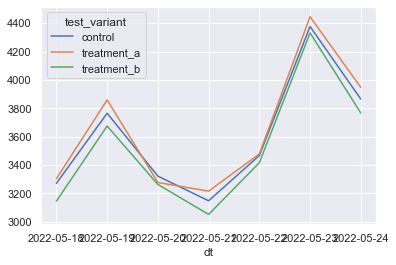

In [22]:
# number of users increased over the weekend
df.pivot_table(index='dt', columns='test_variant', values='visitor_id', aggfunc='nunique').plot()

## Remove outliers

In [23]:
# exclude qa
df = df.loc[~df['test_variant'].str.contains('qa')]

In [24]:
df[['dt', 'test_variant', 'visitor_id', 'order_gmv']].sort_values(by='order_gmv', ascending=False)

,dt,test_variant,visitor_id,order_gmv
56168,2022-05-22,control,9d236492-897b-47d3-b6d4-072235e204cb,10562.07
16597,2022-05-18,treatment_a,32a265eb-f074-4c20-9642-9aaae32d26eb,10143.39
10201,2022-05-23,treatment_a,282a96f9-996e-4aa6-824e-5daf4f6abd45,8063.06
68169,2022-05-24,treatment_b,720fe4e8-9285-4c47-bfe6-4f554b871c73,7172.00
35649,2022-05-20,control,11e25f17-a466-4fa2-9b43-be7b25c4660d,7156.76
...,...,...,...,...
75385,2022-05-20,treatment_a,a5f4a90e-a56a-40f4-ab47-3b154488ee5d,NaN
75386,2022-05-22,treatment_a,20311e5f-87f4-41a4-8894-41fbc73a0b10,NaN
75387,2022-05-24,control,ad3427a6-7e95-46f9-8661-9079edb10afb,NaN
75388,2022-05-22,treatment_a,4bd11c32-e175-4438-92e2-bdc2a82b0ff4,NaN


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='order_gmv', ylabel='Density'>

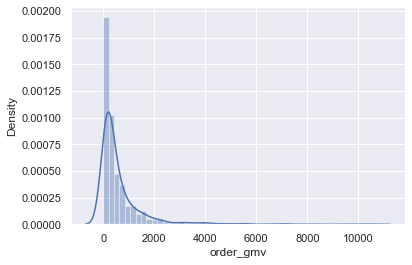

In [25]:
sns.distplot(df['order_gmv'])

<Figure size 1152x288 with 0 Axes>

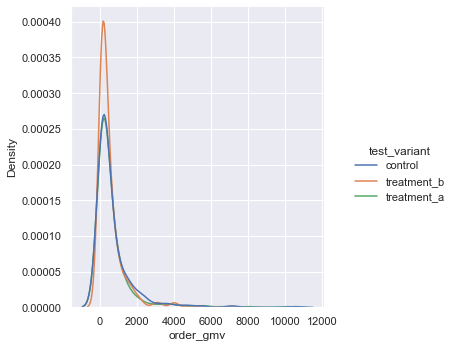

In [26]:
plt.figure(figsize=(16,4)) 
sns.displot(data=df, x='order_gmv', hue='test_variant', kind='kde')

<Figure size 1152x288 with 0 Axes>

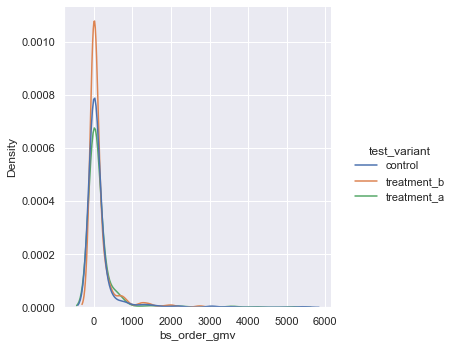

In [27]:
plt.figure(figsize=(16,4)) 
sns.displot(data=df, x='bs_order_gmv', hue='test_variant', kind='kde')

In [28]:
# for some reason, treatment seems to have more large gmv orders
df.loc[df['order_gmv']>3000]['test_variant'].value_counts()

control        16
treatment_a    15
treatment_b    12
Name: test_variant, dtype: int64

In [29]:
# excluding 0 large order from control
df = df.loc[df['order_gmv']<10000]

In [30]:
metrics = df.columns[3:]
# df.groupby(['dt', 'test_variant']).apply(lambda x: x[metrics].sum()/x['visitor_id'].nunique())
dtd_metrics = df.groupby(['dt', 'test_variant']).apply(lambda x: x[metrics].sum()/x['visitor_id'].nunique()).reset_index()
dtd_metrics

,dt,test_variant,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv,bs_order_numbers,bs_units_sold,bs_order_gmv,bs_order_gmv_w_coupon,bs_net_commission,bs_net_commission_w_coupon,bs_new_orders,bs_old_orders,bs_cc_orders,bs_apple_pay_orders,bs_afterpay_orders,bs_paypal_orders,bs_cc_gmv,bs_apple_pay_gmv,bs_afterpay_gmv,bs_paypal_gmv
0,2022-05-18,control,8.745098,6.411765,1.372549,1.058824,1.431373,1.431373,0.901961,2.235294,1.000000,0.568627,1.274510,2.450980,726.977647,726.193333,136.637969,135.853655,0.725490,0.549020,1.039216,0.0,0.000000,0.235294,597.719020,0.0,0.00,129.258627,0.313725,0.607843,181.753137,181.067255,34.530588,33.844706,0.156863,0.156863,0.294118,0.0,0.0,0.019608,175.948039,0.0,0.0,5.805098
1,2022-05-18,treatment_a,8.421053,8.877193,1.649123,1.508772,1.280702,1.175439,0.929825,1.736842,1.035088,0.649123,1.350877,2.526316,527.092281,519.484912,119.643751,112.036382,0.736842,0.614035,1.105263,0.0,0.000000,0.245614,424.283333,0.0,0.00,102.808947,0.350877,0.807018,218.670526,213.371930,48.841982,43.543386,0.228070,0.122807,0.263158,0.0,0.0,0.087719,186.486842,0.0,0.0,32.183684
2,2022-05-18,treatment_b,7.578125,10.531250,1.984375,2.078125,1.312500,1.000000,0.812500,1.703125,1.031250,0.421875,1.406250,2.812500,685.795313,674.557812,144.074839,132.837339,0.593750,0.812500,1.234375,0.0,0.000000,0.171875,643.934687,0.0,0.00,41.860625,0.421875,0.796875,161.914375,160.868870,35.428116,34.382610,0.187500,0.234375,0.375000,0.0,0.0,0.046875,148.834844,0.0,0.0,13.079531
3,2022-05-19,control,7.776316,8.776316,1.394737,1.605263,1.355263,1.197368,0.921053,1.644737,1.039474,0.473684,1.315789,2.592105,647.937368,646.226842,146.057832,144.347305,0.552632,0.763158,1.000000,0.0,0.000000,0.315789,529.727500,0.0,0.00,118.209868,0.302632,0.434211,169.806447,169.367851,31.568750,31.130154,0.144737,0.157895,0.236842,0.0,0.0,0.065789,140.098026,0.0,0.0,29.708421
4,2022-05-19,treatment_a,8.214286,9.226190,1.940476,2.452381,1.535714,1.452381,0.964286,1.892857,1.011905,0.380952,1.345238,1.857143,704.247619,700.795238,150.437414,146.985033,0.678571,0.666667,1.107143,0.0,0.000000,0.238095,573.249643,0.0,0.00,130.997976,0.369048,0.511905,175.590833,175.034286,39.130473,38.573925,0.238095,0.130952,0.321429,0.0,0.0,0.047619,162.693095,0.0,0.0,12.897738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,2022-05-23,treatment_a,9.432836,8.791045,1.447761,2.029851,1.388060,1.507463,1.164179,1.970149,0.970149,0.447761,1.462687,2.835821,816.198358,771.024478,183.641281,138.467400,0.671642,0.791045,1.253731,0.0,0.000000,0.208955,666.186269,0.0,0.00,150.012090,0.343284,0.776119,181.044546,180.187979,38.876543,38.019976,0.179104,0.164179,0.283582,0.0,0.0,0.059701,117.201263,0.0,0.0,63.843284
17,2022-05-23,treatment_b,8.986842,8.328947,1.539474,2.065789,1.421053,1.131579,0.947368,2.210526,1.013158,0.368421,1.184211,1.907895,432.210395,422.197237,96.967088,86.953930,0.644737,0.539474,0.960526,0.0,0.013158,0.210526,361.785526,0.0,1.25,69.174868,0.328947,0.381579,66.247763,65.721447,15.257678,14.731362,0.250000,0.078947,0.250000,0.0,0.0,0.078947,43.631974,0.0,0.0,22.615789
18,2022-05-24,control,6.542373,8.016949,1.627119,2.610169,1.559322,1.237288,1.220339,3.169492,1.016949,0.644068,1.338983,2.203390,767.721017,762.543559,154.350456,149.172998,0.610169,0.728814,1.254237,0.0,0.000000,0.084746,679.368814,0.0,0.00,88.352203,0.220339,0.576271,114.547797,113.656610,27.196924,26.305737,0.169492,0.050847,0.186441,0.0,0.0,0.033898,108.242712,0.0,0.0,6.305085
19,2022-05-24,treatment_a,6.333333,8.666667,1.62963

## Day to Day Metrics Plot

In [31]:
len(metrics)

42

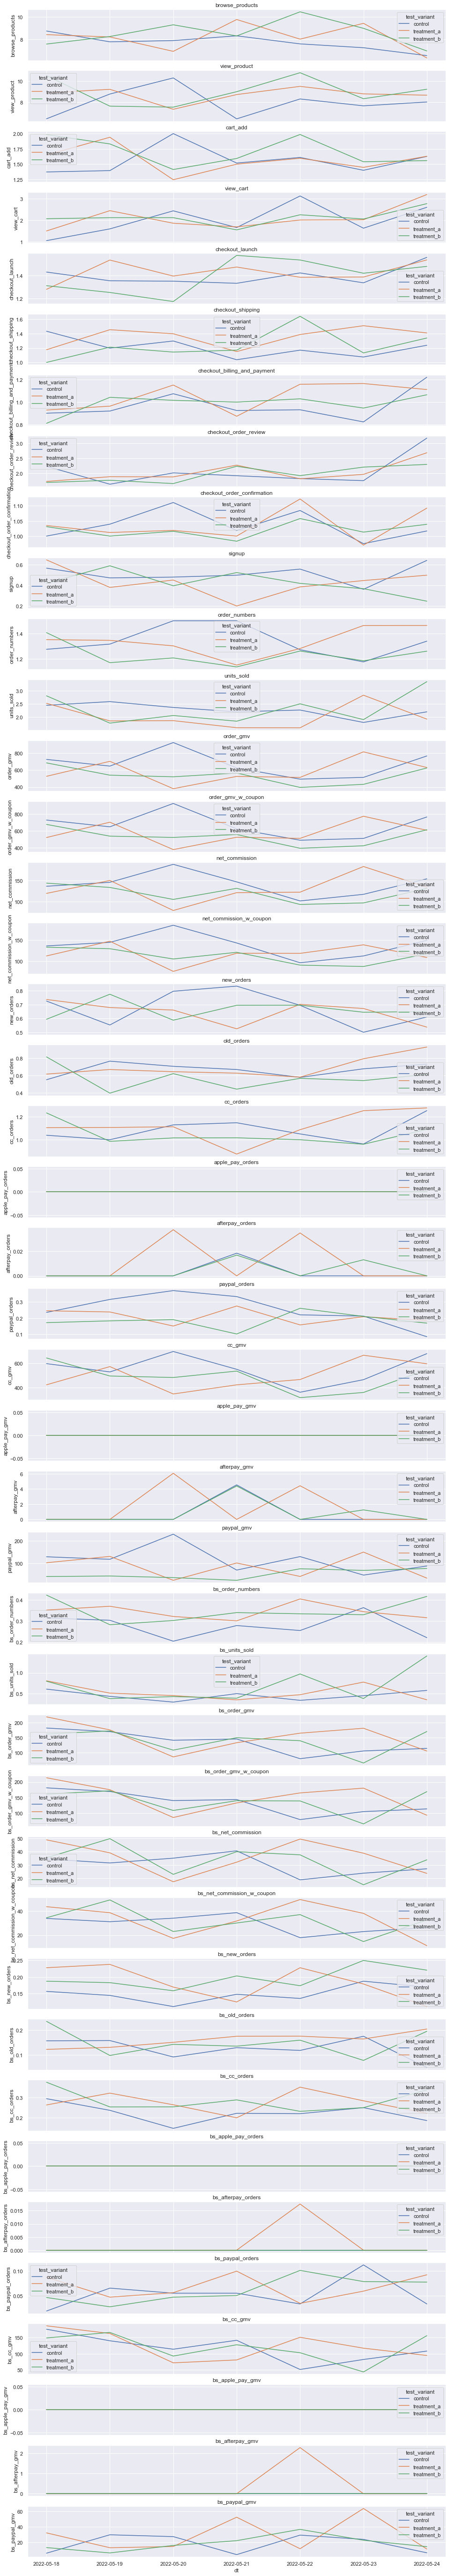

In [32]:
fig, axes = plt.subplots(len(metrics), 1, sharex=True, figsize=(16, 100))

for i, metric in enumerate(metrics):
    sns.lineplot(ax=axes[i], data=dtd_metrics, x='dt', y=metric, hue='test_variant')
    axes[i].set_title(metric)
    # axes[i].set_ylim(ymin=0)

## Metrics Summary

In [33]:
q = """
select 
		test_variant,
        cast(crc32(to_utf8(visitor_id)) % 100 as int) as bucket,
        COUNT(DISTINCT visitor_id) as visitors,

		sum(browse_products) as browse_products,
		sum(view_product) as view_product,
		sum(cart_add) as cart_add,
		sum(view_cart) as view_cart,
		sum(checkout_launch) as checkout_launch,
		sum(checkout_shipping) as checkout_shipping,
		sum(checkout_billing_and_payment) as checkout_billing_and_payment,
		sum(checkout_order_review) as checkout_order_review,
		sum(checkout_order_confirmation) as checkout_order_confirmation,
		sum(signup) as signup,
		
		sum(order_numbers) as order_numbers,
		sum(units_sold) as units_sold,
		sum(order_gmv) as order_gmv,
		sum(order_gmv_w_coupon) as order_gmv_w_coupon,
		sum(net_commission) as net_commission,
		sum(net_commission_w_coupon) as net_commission_w_coupon,
		sum(new_orders) as new_orders,
		sum(old_orders) as old_orders,    
		sum(cc_orders) as cc_orders,
		sum(apple_pay_orders) as apple_pay_orders,
		sum(afterpay_orders) as afterpay_orders,
		sum(paypal_orders) as paypal_orders,
		sum(cc_gmv) as cc_gmv,
		sum(apple_pay_gmv) as apple_pay_gmv,
		sum(afterpay_gmv) as afterpay_gmv,
		sum(paypal_gmv) as paypal_gmv, 

		sum(bs_order_numbers) as bs_order_numbers,
		sum(bs_units_sold) as bs_units_sold,
		sum(bs_order_gmv) as bs_order_gmv,
		sum(bs_order_gmv_w_coupon) as bs_order_gmv_w_coupon,
		sum(bs_net_commission) as bs_net_commission,
		sum(bs_net_commission_w_coupon) as bs_net_commission_w_coupon,
		sum(bs_new_orders) as bs_new_orders,
		sum(bs_old_orders) as bs_old_orders,    
		sum(bs_cc_orders) as bs_cc_orders,
		sum(bs_apple_pay_orders) as bs_apple_pay_orders,
		sum(bs_afterpay_orders) as bs_afterpay_orders,
		sum(bs_paypal_orders) as bs_paypal_orders,
		sum(bs_cc_gmv) as bs_cc_gmv,
		sum(bs_apple_pay_gmv) as bs_apple_pay_gmv,
		sum(bs_afterpay_gmv) as bs_afterpay_gmv,
		sum(bs_paypal_gmv) as bs_paypal_gmv
from {tmp_final_table}
where order_gmv < 10000 or order_gmv is null
group by 1, 2
""".format(tmp_final_table=tmp_final_table)

df_all = pd.read_sql(q, conn)

df_all

,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv,bs_order_numbers,bs_units_sold,bs_order_gmv,bs_order_gmv_w_coupon,bs_net_commission,bs_net_commission_w_coupon,bs_new_orders,bs_old_orders,bs_cc_orders,bs_apple_pay_orders,bs_afterpay_orders,bs_paypal_orders,bs_cc_gmv,bs_apple_pay_gmv,bs_afterpay_gmv,bs_paypal_gmv
0,treatment_b,0,196,807,540,17,8,7,6,3,5,4,4,4.0,6.0,3569.96,3569.96,1138.9700,1138.9700,3.0,1.0,4.0,0.0,0.0,0.0,3569.96,0.0,0.0,0.00,2.0,2.0,1003.00,1003.00,301.220,301.220,2.0,0.0,2.0,0.0,0.0,0.0,1003.00,0.0,0.0,0.00
1,treatment_b,4,183,834,550,40,33,7,5,5,8,6,3,7.0,8.0,3510.96,3510.96,835.9700,835.9700,3.0,4.0,6.0,0.0,0.0,1.0,2826.96,0.0,0.0,684.00,3.0,3.0,2730.24,2730.24,662.780,662.780,2.0,1.0,2.0,0.0,0.0,1.0,2046.24,0.0,0.0,684.00
2,treatment_b,93,194,898,732,23,31,11,12,8,11,7,3,6.0,7.0,1385.22,1385.22,348.1900,348.1900,5.0,1.0,5.0,0.0,0.0,1.0,1344.23,0.0,0.0,40.99,3.0,3.0,745.23,745.23,269.515,269.515,2.0,1.0,3.0,0.0,0.0,0.0,745.23,0.0,0.0,0.00
3,treatment_a,90,215,901,645,34,18,4,3,3,12,3,3,3.0,3.0,915.02,895.02,53.3600,33.3600,1.0,2.0,3.0,0.0,0.0,0.0,915.02,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00
4,treatment_b,91,206,864,714,33,24,16,15,8,16,5,7,6.0,9.0,2850.24,2810.24,507.9100,467.9100,3.0,3.0,4.0,0.0,0.0,2.0,2232.31,0.0,0.0,617.93,2.0,2.0,632.36,632.36,108.680,108.680,0.0,2.0,2.0,0.0,0.0,0.0,632.36,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,treatment_a,77,217,849,634,25,29,13,11,5,9,5,8,6.0,9.0,1558.45,1538.45,303.3200,283.3200,2.0,4.0,6.0,0.0,0.0,0.0,1558.45,0.0,0.0,0.00,3.0,6.0,540.00,540.00,120.000,120.000,1.0,2.0,3.0,0.0,0.0,0.0,540.00,0.0,0.0,0.00
296,control,85,204,813,601,31,44,13,9,7,20,7,8,9.0,19.0,5035.46,5035.46,967.7100,967.7100,4.0,5.0,5.0,0.0,0.0,4.0,849.66,0.0,0.0,4185.80,4.0,6.0,918.04,918.04,191.580,191.580,1.0,3.0,3.0,0.0,0.0,1.0,621.98,0.0,0.0,296.06
297,treatment_b,52,217,960,706,33,35,8,6,5,5,3,5,3.0,11.0,3020.35,3020.35,646.1700,646.1700,2.0,1.0,3.0,0.0,0.0,0.0,3020.35,0.0,0.0,0.00,2.0,6.0,1904.35,1904.35,445.270,445.270,2.0,0.0,2.0,0.0,0.0,0.0,1904.35,0.0,0.0,0.00
298,control,81,233,995,722,26,42,8,9,7,7,4,4,6.0,11.0,1397.30,1397.30,408.1234,408.1234,2.0,4.0,5.0,0.0,0.0,1.0,1155.30,0.0,0.0,242.00,4.0,4.0,964.00,964.00,297.037,297.037,2.0,2.0,3.0,0.0,0.0,1.0,911.00,0.0,0.0,53.00


In [35]:
#  fillna metrics with 0
df_all[metrics].isna().sum().sum()
df_all[metrics] = df_all[metrics].fillna(0)

In [36]:
avg_col_list = ['avg_' + m for m in metrics]
df_all[avg_col_list] = df_all[metrics].div(df_all['visitors'], axis=0)
df_all

,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv,bs_order_numbers,bs_units_sold,bs_order_gmv,bs_order_gmv_w_coupon,bs_net_commission,bs_net_commission_w_coupon,bs_new_orders,bs_old_orders,bs_cc_orders,bs_apple_pay_orders,bs_afterpay_orders,bs_paypal_orders,bs_cc_gmv,bs_apple_pay_gmv,bs_afterpay_gmv,bs_paypal_gmv,avg_browse_products,avg_view_product,avg_cart_add,avg_view_cart,avg_checkout_launch,avg_checkout_shipping,avg_checkout_billing_and_payment,avg_checkout_order_review,avg_checkout_order_confirmation,avg_signup,avg_order_numbers,avg_units_sold,avg_order_gmv,avg_order_gmv_w_coupon,avg_net_commission,avg_net_commission_w_coupon,avg_new_orders,avg_old_orders,avg_cc_orders,avg_apple_pay_orders,avg_afterpay_orders,avg_paypal_orders,avg_cc_gmv,avg_apple_pay_gmv,avg_afterpay_gmv,avg_paypal_gmv,avg_bs_order_numbers,avg_bs_units_sold,avg_bs_order_gmv,avg_bs_order_gmv_w_coupon,avg_bs_net_commission,avg_bs_net_commission_w_coupon,avg_bs_new_orders,avg_bs_old_orders,avg_bs_cc_orders,avg_bs_apple_pay_orders,avg_bs_afterpay_orders,avg_bs_paypal_orders,avg_bs_cc_gmv,avg_bs_apple_pay_gmv,avg_bs_afterpay_gmv,avg_bs_paypal_gmv
0,treatment_b,0,196,807,540,17,8,7,6,3,5,4,4,4.0,6.0,3569.96,3569.96,1138.9700,1138.9700,3.0,1.0,4.0,0.0,0.0,0.0,3569.96,0.0,0.0,0.00,2.0,2.0,1003.00,1003.00,301.220,301.220,2.0,0.0,2.0,0.0,0.0,0.0,1003.00,0.0,0.0,0.00,4.117347,2.755102,0.086735,0.040816,0.035714,0.030612,0.015306,0.025510,0.020408,0.020408,0.020408,0.030612,18.214082,18.214082,5.811071,5.811071,0.015306,0.005102,0.020408,0.0,0.0,0.000000,18.214082,0.0,0.0,0.000000,0.010204,0.010204,5.117347,5.117347,1.536837,1.536837,0.010204,0.000000,0.010204,0.0,0.0,0.000000,5.117347,0.0,0.0,0.000000
1,treatment_b,4,183,834,550,40,33,7,5,5,8,6,3,7.0,8.0,3510.96,3510.96,835.9700,835.9700,3.0,4.0,6.0,0.0,0.0,1.0,2826.96,0.0,0.0,684.00,3.0,3.0,2730.24,2730.24,662.780,662.780,2.0,1.0,2.0,0.0,0.0,1.0,2046.24,0.0,0.0,684.00,4.557377,3.005464,0.218579,0.180328,0.038251,0.027322,0.027322,0.043716,0.032787,0.016393,0.038251,0.043716,19.185574,19.185574,4.568142,4.568142,0.016393,0.021858,0.032787,0.0,0.0,0.005464,15.447869,0.0,0.0,3.737705,0.016393,0.016393,14.919344,14.919344,3.621749,3.621749,0.010929,0.005464,0.010929,0.0,0.0,0.005464,11.181639,0.0,0.0,3.737705
2,treatment_b,93,194,898,732,23,31,11,12,8,11,7,3,6.0,7.0,1385.22,1385.22,348.1900,348.1900,5.0,1.0,5.0,0.0,0.0,1.0,1344.23,0.0,0.0,40.99,3.0,3.0,745.23,745.23,269.515,269.515,2.0,1.0,3.0,0.0,0.0,0.0,745.23,0.0,0.0,0.00,4.628866,3.773196,0.118557,0.159794,0.056701,0.061856,0.041237,0.056701,0.036082,0.015464,0.030928,0.036082,7.140309,7.140309,1.794794,1.794794,0.025773,0.005155,0.025773,0.0,0.0,0.005155,6.929021,0.0,0.0,0.211289,0.015464,0.015464,3.841392,3.841392,1.389253,1.389253,0.010309,0.005155,0.015464,0.0,0.0,0.000000,3.841392,0.0,0.0,0.000000
3,treatment_a,90,215,901,645,34,18,4,3,3,12,3,3,3.0,3.0,915.02,895.02,53.3600,33.3600,1.0,2.0,3.0,0.0,0.0,0.0,915.02,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,4.190698,3.000000,0.158140,0.083721,0.018605,0.013953,0.013953,0.055814,0.013953,0.013953,0.013953,0.013953,4.255907,4.162884,0.248186,0.155163,0.004651,0.009302,0.013953,0.0,0.0,0.000000,4.255907,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
4,treatment_b,91,206,864,714,33,24,16,15,8,16,5,7,6.0,9.0,2850.24,2810.24,507.9100,467.9100,3.0,3.0,4.0,0.0,0.0,2.0,2232.31,0.0,0.0,617.93,2.0,2.0,632.36,632.36,108.680,108.680,0.0,2.0,2.0,0.0,0.0,0.0,632.36,0.0,0.0,0.00,4.194175,3.466019,0.160194,0.116505,0.077670,0.072816,0.0

In [45]:
calculate(df_all, avg_col_list, control, treatment).reset_index()\
    .drop(columns=['index'])#.style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)

,Metric,Treatment A Size,Treatment A Total,Treatment A Mean,Lift_a,Lift_a_%,Trt A P-value,Treatment B Size,Treatment B Total,Treatment B Mean,Lift_b,Lift_b_%,Trt B P-value,Control Size,Control Total,Control Mean
0,avg_browse_products,20693,92931.000000,4.488666,0.041314,9.289652e-03,0.654049,19878,92248.00,4.638709,0.191358,0.043027,0.036308,20419,90836.00,4.447352
1,avg_view_product,20693,67293.000000,3.248293,-0.018093,-5.539250e-03,0.816861,19878,67168.00,3.379070,0.112683,0.034498,0.128078,20419,66745.00,3.266387
2,avg_cart_add,20693,3376.000000,0.163191,-0.007693,-4.501705e-02,0.433248,19878,3469.00,0.174321,0.003437,0.020114,0.713372,20419,3497.00,0.170883
3,avg_view_cart,20693,3318.000000,0.159611,-0.013804,-7.960365e-02,0.381600,19878,3436.00,0.173459,0.000044,0.000255,0.997709,20419,3524.00,0.173415
4,avg_checkout_launch,20693,982.000000,0.047455,-0.001089,-2.243130e-02,0.731597,19878,1030.00,0.051750,0.003207,0.066063,0.285534,20419,991.00,0.048544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,avg_bs_paypal_orders,20693,27.000000,0.001280,0.000078,6.529627e-02,0.820862,19878,30.00,0.001497,0.000296,0.246334,0.373874,20419,25.00,0.001201
38,avg_bs_cc_gmv,20693,52900.804615,2.539053,0.154546,6.481250e-02,0.815119,19878,57134.95,2.850853,0.466346,0.195573,0.431887,20419,49411.52,2.384507
39,avg_bs_apple_pay_gmv,20693,0.000000,0.000000,0.000000,0.000000e+00,NaN,19878,0.00,0.000000,0.000000,0.000000,NaN,20419,0.00,0.000000
40,avg_bs_afterpay_gmv,20693,130.000000,0.005963,0.005963,5.963303e+09,0.318531,19878,0.00,0.000000,0.000000,0.000000,NaN,20419,0.00,0.000000


In [46]:
all_metrics_summery = calculate(df_all, avg_col_list, control, treatment)
all_metrics_summery.to_clipboard()

# Prepare data to session level to slice by Channel

In [71]:
pd.read_sql('drop table if exists {tmp_final_table}_by_channel'.format(tmp_final_table=tmp_final_table), conn)

q = """
create table {tmp_final_table}_by_channel AS
with xo as (

select dt, test_variant, visitor_id, medium, session_id, signin_status,

	-- xo metrics
		sum(coalesce(browse_products, 0)) browse_products,
		sum(coalesce(view_product, 0)) view_product,
 	    sum(coalesce(sm.cart_add,0)) as cart_add,
        sum(coalesce(sm.view_cart,0)) as view_cart,
	    sum(coalesce(sm.checkout_launch,0)) as checkout_launch,
    	sum(coalesce(sm.checkout_shipping,0)) as checkout_shipping,
    	sum(coalesce(sm.checkout_billing_and_payment,0)) as checkout_billing_and_payment,
    	sum(coalesce(sm.checkout_order_review,0)) as checkout_order_review,
	    sum(coalesce(sm.checkout_order_confirmation,0)) as checkout_order_confirmation,
	    sum(coalesce(sm.signup, 0)) as signup

from {tmp_xo_metrics} sm
group by 1, 2, 3, 4, 5, 6

)
, mp as (

select 

		order_date, test_variant, visitor_id, 
		session_id,
	
	-- mp metrics
	    coalesce(count(distinct order_id),0) as order_numbers,
    	count(1) units_sold,
	    sum(coalesce(va.item_gmv,0)) as order_gmv,
	    sum(coalesce(va.item_gmv,0)+coalesce(placed_order_item_coupon_amount, 0)) as order_gmv_w_coupon,
	    sum(coalesce(net_commission, 0)) as net_commission,
	    sum(coalesce(net_commission, 0)+coalesce(placed_order_item_coupon_amount, 0)) as net_commission_w_coupon,
    	coalesce(count(distinct va.new_orders),0) as new_orders,
    	coalesce(count(distinct va.old_orders),0) as old_orders,    
	    coalesce(count(distinct cc_orders), 0) as cc_orders,
	    coalesce(count(distinct apple_pay_orders), 0) as apple_pay_orders,
	    coalesce(count(distinct afterpay_orders), 0) as afterpay_orders,
	    coalesce(count(distinct paypal_orders), 0) as paypal_orders,
	    sum(coalesce(cc_gmv, 0)) as cc_gmv,
	    sum(coalesce(apple_pay_gmv, 0)) as apple_pay_gmv,
	    sum(coalesce(afterpay_gmv, 0)) as afterpay_gmv,
	    sum(coalesce(paypal_gmv, 0)) as paypal_gmv,

	-- bs mp metrics
		coalesce(count(distinct if(if_bs=1, order_id, null)),0) as bs_order_numbers,
    	count(if(if_bs=1, 1, null)) bs_units_sold,
	    sum(coalesce(if(if_bs=1, va.item_gmv, null),0)) as bs_order_gmv,
	    sum(coalesce(if(if_bs=1, va.item_gmv, null),0)+coalesce(if(if_bs=1, placed_order_item_coupon_amount, null), 0)) as bs_order_gmv_w_coupon,
	    sum(coalesce(if(if_bs=1, net_commission, null), 0)) as bs_net_commission,
	    sum(coalesce(if(if_bs=1, net_commission, null), 0)+coalesce(if(if_bs=1, placed_order_item_coupon_amount, null), 0)) as bs_net_commission_w_coupon,
    	coalesce(count(distinct if(if_bs=1, va.new_orders, null)),0) as bs_new_orders,
    	coalesce(count(distinct if(if_bs=1, va.old_orders, null)),0) as bs_old_orders,    
	    coalesce(count(distinct if(if_bs=1, cc_orders, null)), 0) as bs_cc_orders,
	    coalesce(count(distinct if(if_bs=1, apple_pay_orders, null)), 0) as bs_apple_pay_orders,
	    coalesce(count(distinct if(if_bs=1, afterpay_orders, null)), 0) as bs_afterpay_orders,
	    coalesce(count(distinct if(if_bs=1, paypal_orders, null)), 0) as bs_paypal_orders,
	    sum(coalesce(if(if_bs=1, cc_gmv, null), 0)) as bs_cc_gmv,
	    sum(coalesce(if(if_bs=1, apple_pay_gmv, null), 0)) as bs_apple_pay_gmv,
	    sum(coalesce(if(if_bs=1, afterpay_gmv, null), 0)) as bs_afterpay_gmv,
	    sum(coalesce(if(if_bs=1, paypal_gmv, null), 0)) as bs_paypal_gmv
 from {tmp_mp_metrics} va
 group by 1, 2, 3, 4
)

select 
		coalesce(order_date, xo.dt) dt,
		coalesce(xo.test_variant, mp.test_variant) test_variant,
		coalesce(mp.visitor_id, xo.visitor_id) visitor_id,
		coalesce(mp.session_id, xo.session_id) session_id,
		signin_status,
		medium,
		
		
		browse_products,
		view_product,
		cart_add,
		view_cart,
		checkout_launch,
		checkout_shipping,
		checkout_billing_and_payment,
		checkout_order_review,
		checkout_order_confirmation,
		signup,
		
		order_numbers,
		units_sold,
		order_gmv,
		order_gmv_w_coupon,
		net_commission,
		net_commission_w_coupon,
		new_orders,
		old_orders,    
		cc_orders,
		apple_pay_orders,
		afterpay_orders,
		paypal_orders,
		cc_gmv,
		apple_pay_gmv,
		afterpay_gmv,
		paypal_gmv,

		bs_order_numbers,
		bs_units_sold,
		bs_order_gmv,
		bs_order_gmv_w_coupon,
		bs_net_commission,
		bs_net_commission_w_coupon,
		bs_new_orders,
		bs_old_orders,    
		bs_cc_orders,
		bs_apple_pay_orders,
		bs_afterpay_orders,
		bs_paypal_orders,
		bs_cc_gmv,
		bs_apple_pay_gmv,
		bs_afterpay_gmv,
		bs_paypal_gmv
from xo
full join mp
on xo.session_id = mp.session_id

""".format(tmp_xo_metrics=tmp_xo_metrics,
            tmp_final_table=tmp_final_table,
            tmp_mp_metrics=tmp_mp_metrics
			)

# print(q)
pd.read_sql(q, conn)

,rows
0,80103


In [72]:
df_channel = pd.read_sql('select * from {tmp_final_table}_by_channel'.format(tmp_final_table=tmp_final_table), conn)
df_channel

,dt,test_variant,visitor_id,session_id,signin_status,medium,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv,bs_order_numbers,bs_units_sold,bs_order_gmv,bs_order_gmv_w_coupon,bs_net_commission,bs_net_commission_w_coupon,bs_new_orders,bs_old_orders,bs_cc_orders,bs_apple_pay_orders,bs_afterpay_orders,bs_paypal_orders,bs_cc_gmv,bs_apple_pay_gmv,bs_afterpay_gmv,bs_paypal_gmv
0,2022-05-23,control,0faf4a5c-c155-439e-9304-0ac92008a50e,7f2d6a1cf7e8a036ebd6065e809b0a14,PARTIAL_SIGNED_IN,PAID,1,0,0,2,1,3,2,1,1,0,1.0,1.0,759.21,719.21,136.66,96.66,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,759.21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-05-19,control,b1bd01e5-36bd-494d-adbc-8e11dd4a3f33,69d8f713ec8e283e98e576f115af5af7,SIGNED_OUT,PAID,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-05-21,control,e870bc91-d15b-4cae-9f48-ed695cc82aad,a994d68ac9c31caebbdf1fb84b13f1c3,SIGNED_OUT,PAID,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-05-20,treatment_b,faf6aa51-35b7-4082-9e87-9a7f5b99e26e,f57c1ccef430aed1a5d1223bbf44fbff,SIGNED_OUT,DIRECT,3,2,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-05-21,treatment_b,2fcebaaf-8042-4c11-ab8a-1e6196c956d2,b29e34db0aec014ccff8f521ae03d9ea,SIGNED_OUT,PAID,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80098,2022-05-23,treatment_b,30d73bd5-5a8c-432a-9fa9-3bdb75a2ebd2,ba551df7755b668949914ddf0c75322c,SIGNED_OUT,PAID,1,2,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80099,2022-05-22,control,e787a7e2-4324-4041-afc8-1dcf2c6004f5,146a90c1bae83aa0bd1329e72ed6dceb,SIGNED_OUT,PAID,14,3,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80100,2022-05-22,treatment_b,67731a3f-8556-4d04-89c1-41408c4e47d0,50b3266acc47f5045e2fea88468f2a77,SIGNED_OUT,SOCIAL,1,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80101,2022-05-18,control,2d1f8a12-0d52-47f1-97ad-44ecf342ff7e,56f3319f9396564b1154c27d8b06002a,SIGNED_OUT,DIRECT,5,2,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Slice by Channel

In [75]:
# prepare data by slicing `signin_status during xo`
q = """
select 
		medium,
		test_variant,
        cast(crc32(to_utf8(visitor_id)) % 100 as int) as bucket,
        COUNT(DISTINCT visitor_id) as visitors,

		sum(browse_products) as browse_products,
		sum(view_product) as view_product,
		sum(cart_add) as cart_add,
		sum(view_cart) as view_cart,
		sum(checkout_launch) as checkout_launch,
		sum(checkout_shipping) as checkout_shipping,
		sum(checkout_billing_and_payment) as checkout_billing_and_payment,
		sum(checkout_order_review) as checkout_order_review,
		sum(checkout_order_confirmation) as checkout_order_confirmation,
		sum(signup) as signup,
		
		sum(order_numbers) as order_numbers,
		sum(units_sold) as units_sold,
		sum(order_gmv) as order_gmv,
		sum(order_gmv_w_coupon) as order_gmv_w_coupon,
		sum(net_commission) as net_commission,
		sum(net_commission_w_coupon) as net_commission_w_coupon,
		sum(new_orders) as new_orders,
		sum(old_orders) as old_orders,    
		sum(cc_orders) as cc_orders,
		sum(apple_pay_orders) as apple_pay_orders,
		sum(afterpay_orders) as afterpay_orders,
		sum(paypal_orders) as paypal_orders,
		sum(cc_gmv) as cc_gmv,
		sum(apple_pay_gmv) as apple_pay_gmv,
		sum(afterpay_gmv) as afterpay_gmv,
		sum(paypal_gmv) as paypal_gmv,

		sum(bs_order_numbers) as bs_order_numbers,
		sum(bs_units_sold) as bs_units_sold,
		sum(bs_order_gmv) as bs_order_gmv,
		sum(bs_order_gmv_w_coupon) as bs_order_gmv_w_coupon,
		sum(bs_net_commission) as bs_net_commission,
		sum(bs_net_commission_w_coupon) as bs_net_commission_w_coupon,
		sum(bs_new_orders) as bs_new_orders,
		sum(bs_old_orders) as bs_old_orders,    
		sum(bs_cc_orders) as bs_cc_orders,
		sum(bs_apple_pay_orders) as bs_apple_pay_orders,
		sum(bs_afterpay_orders) as bs_afterpay_orders,
		sum(bs_paypal_orders) as bs_paypal_orders,
		sum(bs_cc_gmv) as bs_cc_gmv,
		sum(bs_apple_pay_gmv) as bs_apple_pay_gmv,
		sum(bs_afterpay_gmv) as bs_afterpay_gmv,
		sum(bs_paypal_gmv) as bs_paypal_gmv
from {tmp_final_table}_by_channel
where order_gmv < 10000 or order_gmv is null
group by 1, 2, 3
""".format(tmp_final_table=tmp_final_table)

df_channel = pd.read_sql(q, conn)

df_channel

,medium,test_variant,bucket,visitors,browse_products,view_product,cart_add,view_cart,checkout_launch,checkout_shipping,checkout_billing_and_payment,checkout_order_review,checkout_order_confirmation,signup,order_numbers,units_sold,order_gmv,order_gmv_w_coupon,net_commission,net_commission_w_coupon,new_orders,old_orders,cc_orders,apple_pay_orders,afterpay_orders,paypal_orders,cc_gmv,apple_pay_gmv,afterpay_gmv,paypal_gmv,bs_order_numbers,bs_units_sold,bs_order_gmv,bs_order_gmv_w_coupon,bs_net_commission,bs_net_commission_w_coupon,bs_new_orders,bs_old_orders,bs_cc_orders,bs_apple_pay_orders,bs_afterpay_orders,bs_paypal_orders,bs_cc_gmv,bs_apple_pay_gmv,bs_afterpay_gmv,bs_paypal_gmv
0,SEARCH,control,27,57,227,165,2,2,1,1,1,1,1,0,1.0,12.0,84.00,84.00,0.00,0.00,0.0,1.0,1.0,0.0,0.0,0.0,84.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DIRECT,control,8,45,241,141,7,12,2,1,1,4,3,0,1.0,2.0,347.14,347.14,62.48,62.48,0.0,1.0,1.0,0.0,0.0,0.0,347.14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,SOCIAL,treatment_b,26,2,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SEARCH,control,50,63,186,67,13,3,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HOUZZ_OWN,treatment_b,27,2,1,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1223,EMAIL,control,35,11,61,70,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1224,PAID,control,28,185,414,227,11,24,10,14,8,2,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1225,DIRECT,treatment_b,65,40,108,55,2,4,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1226,EMAIL,control,22,11,23,14,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
def metricSummary(df):
    df[metrics] = df[metrics].fillna(0)
    df[avg_col_list] = df[metrics].div(df['visitors'], axis=0)
    # metricSum = calculate(df, avg_col_list, control, treatment).reset_index()\
    # .drop(columns=['index']).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)
    # return metricSum
    return calculate(df, avg_col_list, control, treatment)#.reset_index()#\
    #.drop(columns=['index']).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)


In [78]:
df_channel.groupby('medium').apply(metricSummary).to_clipboard()
pd.set_option('display.max_rows', 10)
df_channel.groupby('medium').apply(metricSummary).style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)

# Browse Ranking

In [ ]:
# br = pd.read_sql('select * from {tmp_browse_ranking} where if_bs = 1'.format(tmp_browse_ranking=tmp_browse_ranking), conn)
# br

<Figure size 1152x288 with 0 Axes>

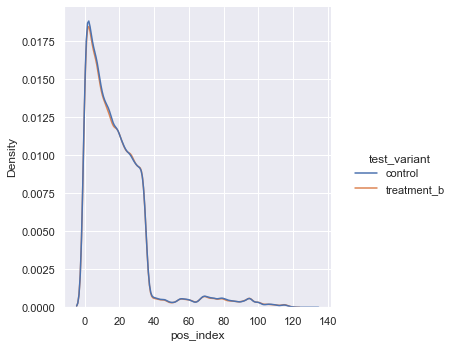

In [81]:
# bs browse ranking vs non-bs
plt.figure(figsize=(16,4)) 
sns.displot(data=br, x='pos_index', hue='test_variant', kind='kde')

In [49]:
pos = pd.read_sql('select test_variant, if_bs, histogram(pos_index) as pos_hist from {tmp_browse_ranking} group by 1, 2'.format(tmp_browse_ranking=tmp_browse_ranking), conn)
pos

,test_variant,if_bs,pos_hist
0,treatment_a,1,"{'0': 20077, '1': 17951, '2': 14565, '3': 15462, '4': 14066, '5': 12489, '6': 14104, '7': 13427, '8': 12155, '9': 11914, '10': 11252, '11': 10761, '12': 11481, '13': 10167, '14': 10297, '15': 9796, '16': 9412, '17': 9431, '18': 9133, '19': 10373, '20': 8879, '21': 8512, '22': 8389, '23': 8164, '24': 8362, '25': 7986, '26': 9333, '27': 8022, '28': 7743, '29': 7539, '30': 7470, '31': 7548, '32': 7290, '33': 8728, '34': 7098, '35': 7019, '36': 579, '37': 673, '38': 810, '39': 738, '40': 766, '41': 656, '42': 631, '43': 725, '44': 587, '45': 603, '46': 673, '47': 644, '48': 557, '49': 523, '50': 500, '51': 630, '52': 487, '53': 536, '54': 653, '55': 618, '56': 664, '57': 523, '58': 625, '59': 596, '60': 589, '61': 644, '62': 553, '63': 475, '64': 444, '65': 449, '66': 571, '67': 559, '68': 706, '69': 648, '70': 575, '71': 520, '72': 609, '73': 529, '74': 572, '75': 603, '76': 464, '77': 508, '78': 521, '79': 639, '80': 500, '81': 452, '82': 581, '83': 383, '84': 424, '85': 515, '86': 358, '87': 490, '88': 412, '89': 454, '90': 91, '91': 144, '92': 168, '93': 118, '94': 186, '95': 433, '96': 93, '97': 141, '98': 71, '99': 73, ...}"
1,treatment_b,0,"{'0': 68087, '1': 69899, '2': 73156, '3': 72104, '4': 72776, '5': 74102, '6': 72416, '7': 72791, '8': 73685, '9': 74134, '10': 74563, '11': 74636, '12': 73951, '13': 74914, '14': 74835, '15': 74967, '16': 75277, '17': 75083, '18': 75024, '19': 73713, '20': 75199, '21': 75395, '22': 75325, '23': 75370, '24': 75268, '25': 75258, '26': 73927, '27': 75057, '28': 75170, '29': 75211, '30': 75221, '31': 75007, '32': 74952, '33': 73465, '34': 74773, '35': 75186, '36': 9448, '37': 9405, '38': 9247, '39': 9252, '40': 9242, '41': 9281, '42': 9330, '43': 9241, '44': 9367, '45': 9303, '46': 9292, '47': 9291, '48': 9398, '49': 9359, '50': 9404, '51': 9278, '52': 9380, '53': 9295, '54': 9185, '55': 9229, '56': 9174, '57': 9264, '58': 9147, '59': 9161, '60': 9146, '61': 9067, '62': 9198, '63': 9245, '64': 9226, '65': 9221, '66': 9128, '67': 9089, '68': 8961, '69': 9031, '70': 9014, '71': 9096, '72': 8968, '73': 9070, '74': 8938, '75': 8893, '76': 9035, '77': 8986, '78': 8985, '79': 8790, '80': 8929, '81': 8965, '82': 8889, '83': 8998, '84': 8938, '85': 8869, '86': 8993, '87': 8875, '88': 8926, '89': 8865, '90': 1634, '91': 1564, '92': 1539, '93': 1587, '94': 1522, '95': 1133, '96': 1388, '97': 1326, '98': 1349, '99': 1220, ...}"
2,treatment_a,0,"{'0': 68354, '1': 70065, '2': 73147, '3': 71998, '4': 73143, '5': 74475, '6': 72649, '7': 73116, '8': 74182, '9': 74219, '10': 74678, '11': 74980, '12': 74069, '13': 75207, '14': 74892, '15': 75212, '16': 75447, '17': 75250, '18': 75380, '19': 73970, '20': 75329, '21': 75559, '22': 75561, '23': 75646, '24': 75322, '25': 75533, '26': 74054, '27': 75241, '28': 75379, '29': 75445, '30': 75366, '31': 75146, '32': 75270, '33': 73686, '34': 75149, '35': 75107, '36': 9776, '37': 9671, '38': 9527, '39': 9586, '40': 9551, '41': 9647, '42': 9658, '43': 9550, '44': 9679, '45': 9647, '46': 9565, '47': 9581, '48': 9663, '49': 9682, '50': 9696, '51': 9561, '52': 9695, '53': 9641, '54': 9512, '55': 9537, '56': 9480, '57': 9612, '58': 9500, '59': 9499, '60': 9455, '61': 9393, '62': 9474, '63': 9536, '64': 9563, '65': 9553, '66': 9423, '67': 9424, '68': 9259, '69': 9303, '70': 9357, '71': 9404, '72': 9260, '73': 9331, '74': 9278, '75': 9237, '76': 9361, '77': 9309, '78': 9291, '79': 9158, '80': 9284, '81': 9316, '82': 9180, '83': 9370, '84': 9314, '85': 9206, '86': 9345, '87': 9204, '88': 9264, '89': 9217, '90': 1636, '91': 1580, '92': 1553, '93': 1593, '94': 1486, '95': 1109, '96': 1378, '97': 1296, '98': 1310, '99': 1179, ...}"
3,treatment_b,1,"{'0': 19729, '1': 17477, '2': 13931, '3': 14725, '4': 13776, '5': 12224, '6': 13694, '7': 13104, '8': 12008, '9': 11378, '10': 10785, '11': 10534, '12': 11041, '13': 9901, '14': 9817, '15': 9519, '16': 9057, '17': 9088, '18': 9001, '19': 10151, '20': 8522, '21': 8184, '22': 8108, '23': 7911,

In [ ]:
fig, axes = plt.subplots(len(metrics), 1, sharex=True, figsize=(16, 100))

for i, metric in enumerate(metrics):
    sns.lineplot(ax=axes[i], data=dtd_metrics, x='dt', y=metric, hue='test_variant')
    axes[i].set_title(metric)

In [62]:
pos['pos_hist'][5].keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '119'])

In [ ]:
# fig, axes = plt.subplots(len(pos), 1, sharex=True, figsize=(16, 100))

# for i in range(len(pos)):
#     title = pos['test_variant'][i] + '_' + str(pos['if_bs'][i])
#     hist = pos['pos_hist'][i]
#     plt.scatter(ax=axes[i], x=hist.keys(), y=hist.values())

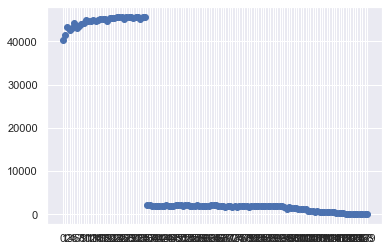

In [104]:
non_bs_pos_ctrl = non_bs_pos.loc[non_bs_pos['test_variant']=='control', '_col1'][0]
plt.scatter(non_bs_pos_ctrl.keys(), non_bs_pos_ctrl.values())

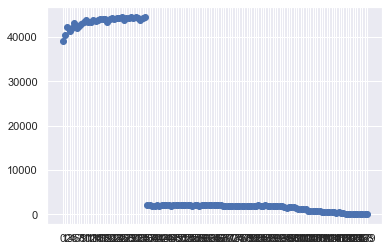

In [107]:
non_bs_pos_trt = non_bs_pos.loc[non_bs_pos['test_variant']=='treatment_b', '_col1'][1]
plt.scatter(non_bs_pos_trt.keys(), non_bs_pos_trt.values())

In [72]:
# browse to click rate

q = """
with dv as (
select 
		dt, 
		visitor_id, 
		test_variant,
		
		if_bs, 
		count(object_id) imps,
		count(distinct object_id) unique_product_imps,
		count(if(any_click = true, object_id, null)) clicks,
		count(distinct if(any_click = true, object_id, null)) unique_product_clicks
from {tmp_browse_ranking} 
group by 1, 2, 3, 4
)
select 
		test_variant, 
		cast(crc32(to_utf8(visitor_id)) % 100 as int) as bucket,
        COUNT(DISTINCT visitor_id) as visitors,

		sum(imps) imps,
		sum(unique_product_imps) unique_product_imps,
		sum(clicks) clicks,
		sum(unique_product_clicks) unique_product_clicks,
		sum(clicks)/sum(imps) ctr,
		sum(unique_product_clicks)/sum(unique_product_imps) unique_ctr,


		sum(if(if_bs=1, imps, 0)) bs_imps,
		sum(if(if_bs=1, unique_product_imps, 0)) bs_unique_product_imps,
		sum(if(if_bs=1, clicks, 0)) bs_clicks,
		sum(if(if_bs=1, unique_product_clicks, 0)) bs_unique_product_clicks,
		sum(if(if_bs=1, clicks, 0))/sum(if(if_bs=1, imps, 0)) bs_ctr,
		sum(if(if_bs=1, unique_product_clicks, 0))/sum(if(if_bs=1, unique_product_imps, 0)) unique_bs_ctr,


		sum(if(if_bs=0, imps, 0)) nonbs_imps,
		sum(if(if_bs=0, unique_product_imps, 0)) nonbs_unique_product_imps,
		sum(if(if_bs=0, clicks, 0)) nonbs_clicks,
		sum(if(if_bs=0, unique_product_clicks, 0)) nonbs_unique_product_clicks,
		sum(if(if_bs=0, clicks, 0))/sum(if(if_bs=1, imps, 0)) bs_ctr,
		sum(if(if_bs=0, unique_product_clicks, 0))/sum(if(if_bs=1, unique_product_imps, 0)) unique_bs_ctr

from dv
group by 1, 2
""".format(tmp_browse_ranking=tmp_browse_ranking )

df_browse_click = pd.read_sql(q, conn)
df_browse_click




,test_variant,bucket,visitors,imps,unique_product_imps,clicks,unique_product_clicks,ctr,unique_ctr,bs_imps,bs_unique_product_imps,bs_clicks,bs_unique_product_clicks,bs_ctr,unique_bs_ctr,nonbs_imps,nonbs_unique_product_imps,nonbs_clicks,nonbs_unique_product_clicks,bs_ctr,unique_bs_ctr
0,control,74,156,27691,22462,176,173,0,0,3312,2630,16,15,0,0,24379,19832,160,158,0,0
1,treatment_b,47,153,29488,23202,202,192,0,0,3105,2319,35,34,0,0,26383,20883,167,158,0,0
2,treatment_b,86,144,29516,22256,217,202,0,0,3811,2647,35,31,0,0,25705,19609,182,171,0,0
3,control,93,184,51347,39410,372,367,0,0,5872,4039,36,36,0,0,45475,35371,336,331,0,0
4,control,89,167,42749,33680,190,187,0,0,4063,2828,24,24,0,0,38686,30852,166,163,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,treatment_a,40,162,29912,22891,191,187,0,0,3836,2832,24,24,0,0,26076,20059,167,163,0,0
296,treatment_a,6,153,32149,24356,212,209,0,0,3744,2589,43,43,0,0,28405,21767,169,166,0,0
297,control,12,175,26286,21439,165,160,0,0,3487,2638,26,25,0,0,22799,18801,139,135,0,0
298,treatment_b,30,154,27352,21759,187,183,0,0,3478,2631,27,27,0,0,23874,19128,160,156,0,0


In [75]:
bc_metrics = df_browse_click.columns[3:]
df_browse_click[bc_metrics].isna().sum().sum()
# df_browse_click[bc_metrics] = df_browse_click[bc_metrics].fillna(0)

0

In [76]:
avg_col_list = ['avg_' + m for m in bc_metrics]
df_browse_click[avg_col_list] = df_browse_click[bc_metrics].div(df_browse_click['visitors'], axis=0)
df_browse_click

ValueError: Columns must be same length as key

In [69]:
calculate(df_browse_click, avg_col_list, control, treatment).reset_index()\
    .drop(columns=['index'])#.style.format({"Treatment Mean":"{:.4f}", "Control Mean":"{:.4f}", "Lift":"{:.5f}", "Lift_%":"{:.2%}", "P-value":"{:.4f}"}).apply(color_negative_red, axis = 1)

,Metric,Treatment A Size,Treatment A Total,Treatment A Mean,Lift_a,Lift_a_%,Trt A P-value,Treatment B Size,Treatment B Total,Treatment B Mean,Lift_b,Lift_b_%,Trt B P-value,Control Size,Control Total,Control Mean
0,avg_imps,16245,3624412.0,223.196236,0.680562,0.003058,0.893884,15592,3587470.0,230.290238,7.774564,0.034939,0.126109,16032,3572225.0,222.515674
1,avg_unique_product_imps,16245,2773680.0,170.731900,-0.940434,-0.005478,0.801889,15592,2765576.0,177.477377,5.805043,0.033815,0.134167,16032,2756975.0,171.672333
2,avg_clicks,16245,22326.0,1.375864,-0.011260,-0.008118,0.787665,15592,23373.0,1.499272,0.112148,0.080850,0.010907,16032,22283.0,1.387124
3,avg_unique_product_clicks,16245,21783.0,1.342327,-0.009770,-0.007226,0.809526,15592,22816.0,1.463467,0.111370,0.082368,0.009606,16032,21720.0,1.352097
4,avg_bs_imps,16245,409787.0,25.233866,0.478655,0.019336,0.322849,15592,397378.0,25.518993,0.763782,0.030853,0.113787,16032,397228.0,24.755211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,avg_bs_unique_product_clicks,16245,2774.0,0.170983,0.001846,0.010913,0.775783,15592,2981.0,0.191093,0.021956,0.129810,0.000794,16032,2719.0,0.169138
8,avg_nonbs_imps,16245,3214625.0,197.962370,0.201907,0.001021,0.966037,15592,3190092.0,204.771245,7.010783,0.035451,0.138576,16032,3174997.0,197.760462
9,avg_nonbs_unique_product_imps,16245,2482849.0,152.830204,-1.023931,-0.006655,0.772426,15592,2481543.0,159.246854,5.392720,0.035051,0.141051,16032,2471053.0,153.854135
10,avg_nonbs_clicks,16245,19461.0,1.199262,-0.013558,-0.011179,0.722580,15592,20311.0,1.302982,0.090162,0.074341,0.027380,16032,19481.0,1.212820


In [70]:
calculate(df_browse_click, avg_col_list, control, treatment).reset_index()\
    .drop(columns=['index']).to_clipboard()

# Visits to Best Seller topic pages

In [71]:
q = """
select pv.dt, test_variant, count(distinct vb.visitor_id) visitors, count(1) page_views, sum(active_time_on_page) active_time_on_page, sum(total_time_on_page) total_time_on_page 
from {tmp_visitor_base} vb
join (
		select dt, visitor_id, topic, url, active_time_on_page, total_time_on_page
		from l2.page_views_daily
		where dt >= '2022-05-14'
		and url like '%products%/label--best-seller'
) pv
on vb.visitor_id = pv.visitor_id and pv.dt >= vb.dt
group by 1, 2
order by 1, 2
""".format(tmp_visitor_base=tmp_visitor_base)

df_topics = pd.read_sql(q, conn)
df_topics

,dt,test_variant,visitors,page_views,active_time_on_page,total_time_on_page
0,2022-05-18,treatment_a,3,4,46,190
1,2022-05-18,treatment_b,2,2,99,418
2,2022-05-19,treatment_a,1,1,2,657
3,2022-05-20,treatment_a,2,2,0,0
4,2022-05-21,treatment_a,2,2,0,0
5,2022-05-21,treatment_b,2,2,0,0
6,2022-05-22,treatment_a,2,2,25,661
7,2022-05-22,treatment_b,4,5,147,435
8,2022-05-23,treatment_a,5,6,44,44
9,2022-05-24,treatment_a,2,2,15,73
